# 答题卡识别

In [1]:
import numpy as np
import cv2

import matplotlib
import matplotlib.pyplot as plt
# Allow image embeding in notebook
%matplotlib inline

### 函数

In [2]:
# ----------------------------------------------------------------------
# 【4边形4点排序函数】
#     输入：4边形任意顺序的4个顶点
#     输出：按照一定顺序的4个顶点
# ----------------------------------------------------------------------
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")# 按照左上、右上、右下、左下顺序初始化坐标
 
    s = pts.sum(axis = 1)# 计算点xy的和
    rect[0] = pts[np.argmin(s)]# 左上角的点的和最小
    rect[2] = pts[np.argmax(s)]# 右下角的点的和最大
 
    diff = np.diff(pts, axis = 1)# 计算点xy之间的差
    rect[1] = pts[np.argmin(diff)]# 右上角的差最小
    rect[3] = pts[np.argmax(diff)]# 左下角的差最小
 
    return rect# 返回4个顶点的顺序


# ----------------------------------------------------------------------
# 【4点变换函数】
#      输入：原始图像+4个顶点
#      输出：变换后的图像
# ----------------------------------------------------------------------
def four_point_transform(image, pts):
    rect = order_points(pts)# 获得一致的顺序的点并分别解包他们
    (tl, tr, br, bl) = rect
 
    # 计算新图像的宽度(x)
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))#右下和左下之间距离
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))#右上和左上之间距离
    maxWidth = max(int(widthA), int(widthB))# 取大者
 
    # 计算新图像的高度(y)
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))#右上和右下之间距离
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))#左上和左下之间距离
    maxHeight = max(int(heightA), int(heightB))
 
    # 有了新图像的尺寸, 构造透视变换后的顶点集合
    dst = np.array([
        [0, 0], # -------------------------左上
        [maxWidth - 1, 0], # --------------右上
        [maxWidth - 1, maxHeight - 1], # --右下
        [0, maxHeight - 1]], # ------------左下
            dtype = "float32")
 
    M = cv2.getPerspectiveTransform(rect, dst)# 计算透视变换矩阵
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight)) # 执行透视变换
 
    return warped #返回透视变换后的图像

# --------------------------------------------------------------------
# 【轮廓排序函数】
#      输入：轮廓，排序方式
#      输出：排序好的轮廓
# --------------------------------------------------------------------
def sort_contours(cnts, method="left-to-right"):
    # 初始化逆序标志和排序索引
    reverse = False
    i = 0

    # 是否需逆序处理
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # 是否需要按照y坐标函数
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # 构造包围框列表，并从上到下对它们进行排序
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b: b[1][i], reverse=reverse))

    # 返回已排序的轮廓线和边框列表
    return cnts, boundingBoxes

## 一、切割答题区域
### 1、读入图片+预处理

(-0.5, 3318.5, 2346.5, -0.5)

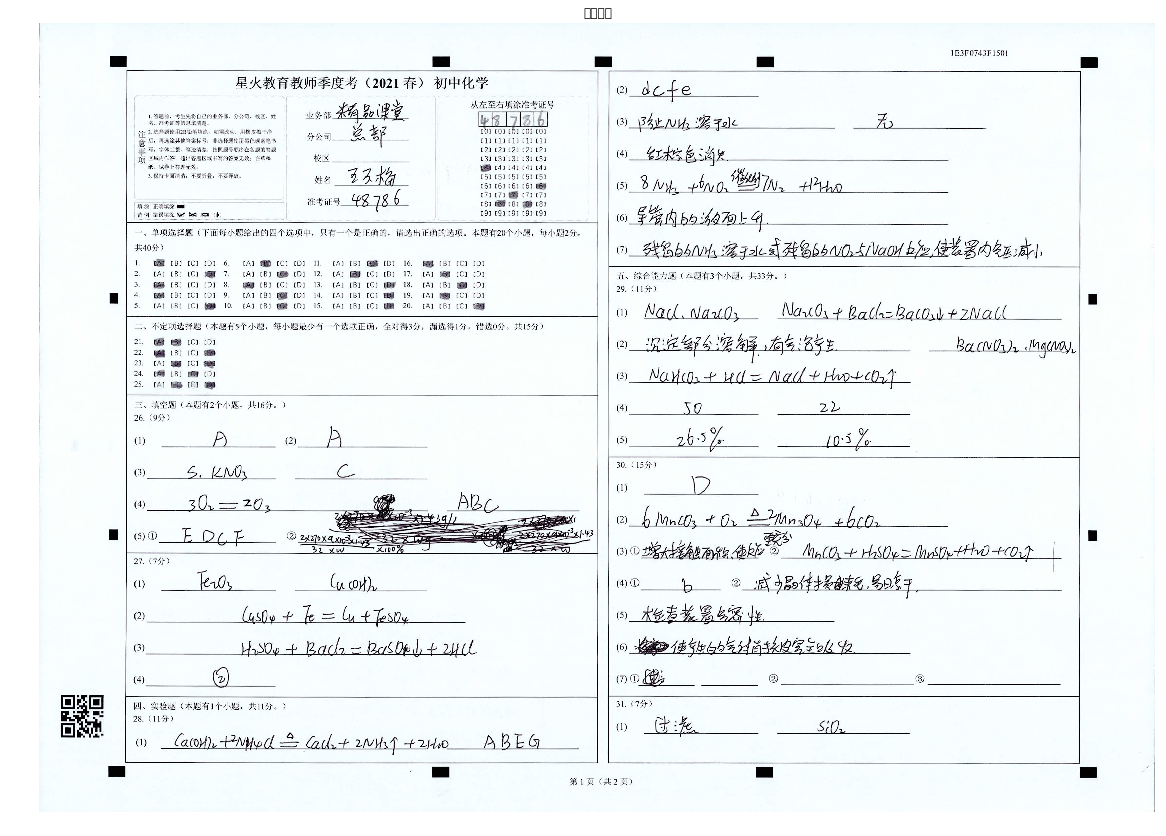

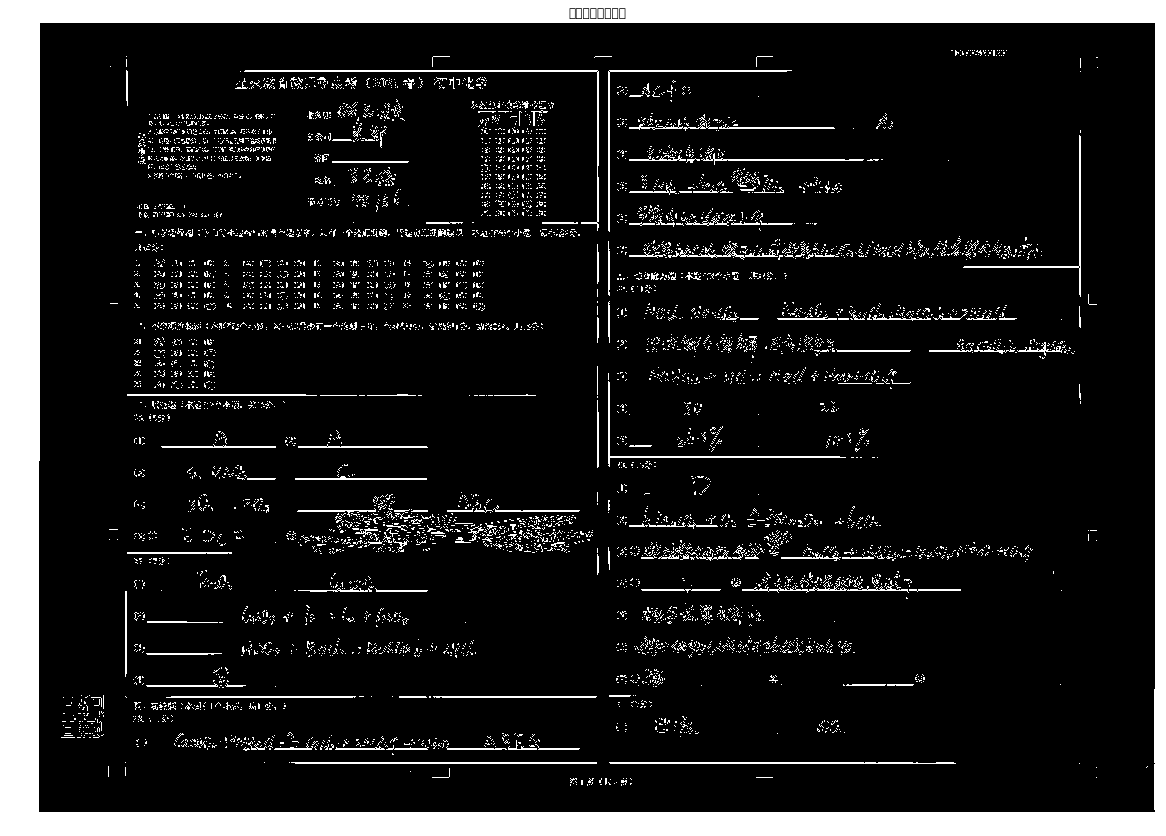

In [3]:
from imutils import auto_canny, contours

# 【1】读入图片+预处理
image = cv2.imread('paper-1-1.jpg')# 加载图片
# cv2.imshow("Original", image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)# 转灰度
blurred = cv2.GaussianBlur(gray, (5, 5), 0)# 高斯模糊

# kernel = np.ones((3, 3), np.uint8)
# blurred = cv2.erode(blurred, kernel, iterations=1) #腐蚀
# blurred = cv2.dilate(blurred, kernel, iterations=2) #膨胀
# blurred = cv2.erode(blurred, kernel, iterations=1) #腐蚀
# blurred = cv2.dilate(blurred, kernel, iterations=2) #膨胀

# edged = cv2.Canny(blurred, 75, 200)# 边缘检测
edged = auto_canny(blurred) # 边缘检测

# fig = plt.figure(figsize=(15, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))#plt显示是RGB顺序
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.imshow(edged,cmap ='gray')
# plt.axis('off')

fig = plt.figure(figsize=(20, 30))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(u"原始图片")
plt.axis('off')

fig = plt.figure(figsize=(20, 30))
plt.imshow(edged, cmap ='gray')
plt.title(u"边缘检测后的图片")
plt.axis('off')

## 一、切割答题区域
### 2、提取图片中的左右答题轮廓

findContours函数详解：https://blog.csdn.net/laobai1015/article/details/76400725

findContours 函数第二个参数取值类型：
- RETR_EXTERNAL	只检测最外围轮廓，包含在外围轮廓内的内围轮廓被忽略
- RETR_LIST	检测所有的轮廓，包括内围、外围轮廓，但是检测到的轮廓不建立等级关 系，彼此之间独立，没有等级关系，这就意味着这个检索模式下不存在父轮廓或内嵌轮廓
- ETR_CCOMP	检测所有的轮廓，但所有轮廓只建立两个等级关系，外围为顶层，若外围 内的内围轮廓还包含了其他的轮廓信息，则内围内的所有轮廓均归属于顶层
- RETR_TREE	检测所有轮廓，所有轮廓建立一个等级树结构。外层轮廓包含内层轮廓，内层轮廓还可以继续包含内嵌轮廓。

findContours 函数第三个参数取值类型：
- CHAIN_APPROX_NONE 保存物体边界上所有连续的轮廓点到contours向量内
- CHAIN_APPROX_SIMPLE 仅保存轮廓的拐点信息，把所有轮廓拐点处的点保存入contours向量内，拐点与拐点之间直线段上的信息点不予保留
- CHAIN_APPROX_TC89_L1，CHAIN_APPROX_TC89_KCOS使用teh-Chinl chain 近似算法

原始图片检测的轮廓总数： 59
轮廓周长： 6934.568541526794
原始轮廓的边数: 77 , 近似轮廓的边数: 4
轮廓周长： 6935.639609217644
原始轮廓的边数: 86 , 近似轮廓的边数: 4
[[[ 261  143]]

 [[ 256 2199]]

 [[1661 2201]]

 [[1662  145]]]
[[[1695  144]]

 [[1692 2200]]

 [[3095 2202]]

 [[3098  147]]]


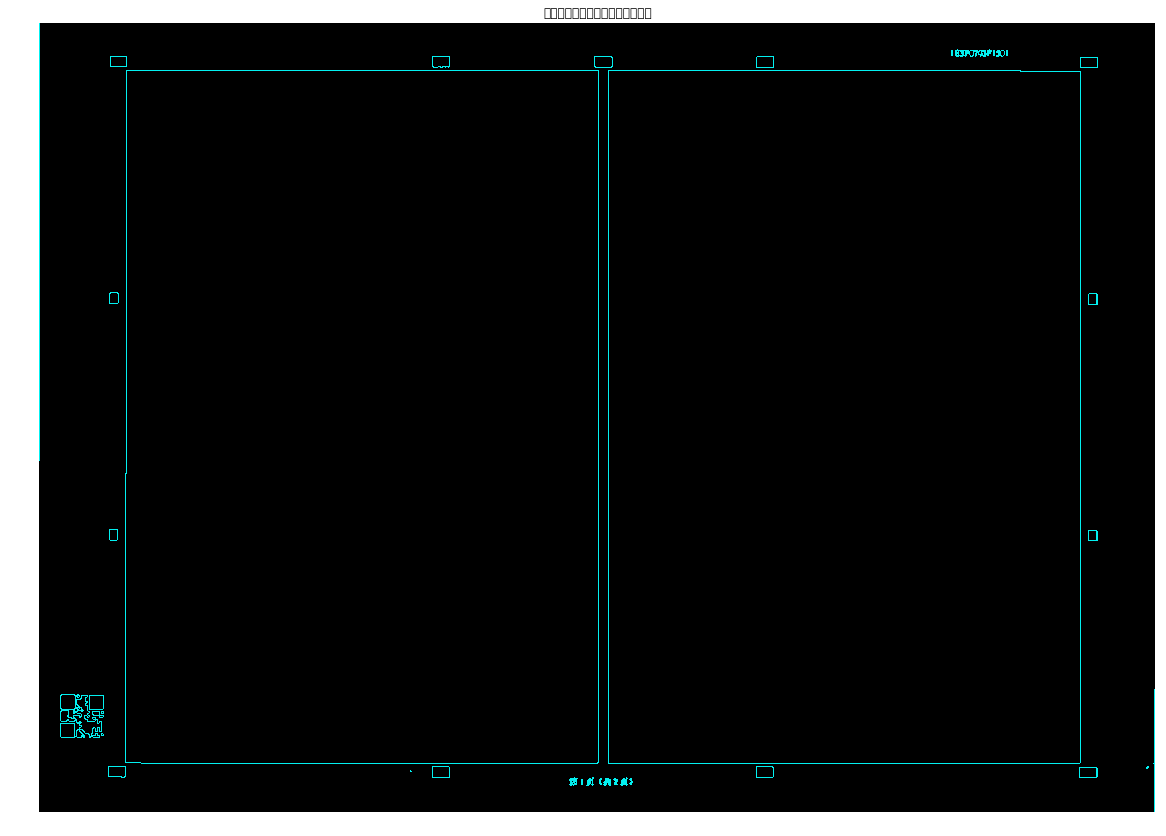

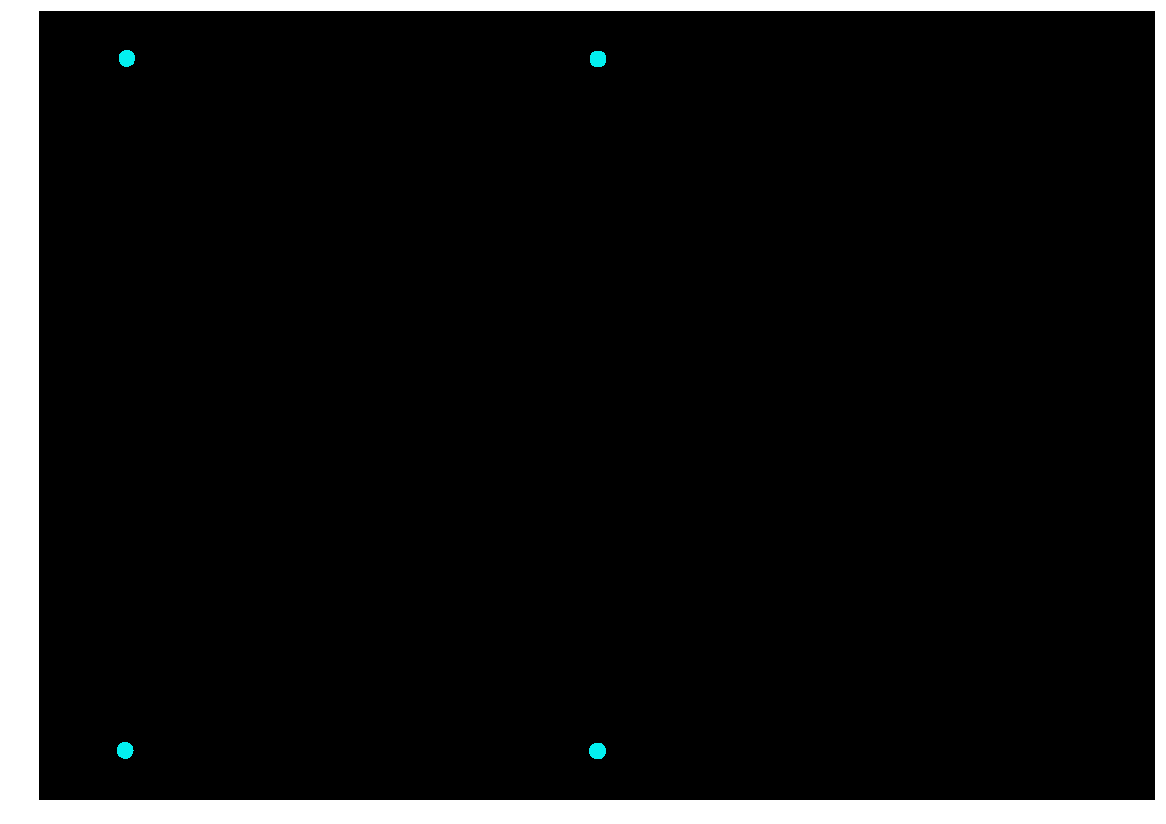

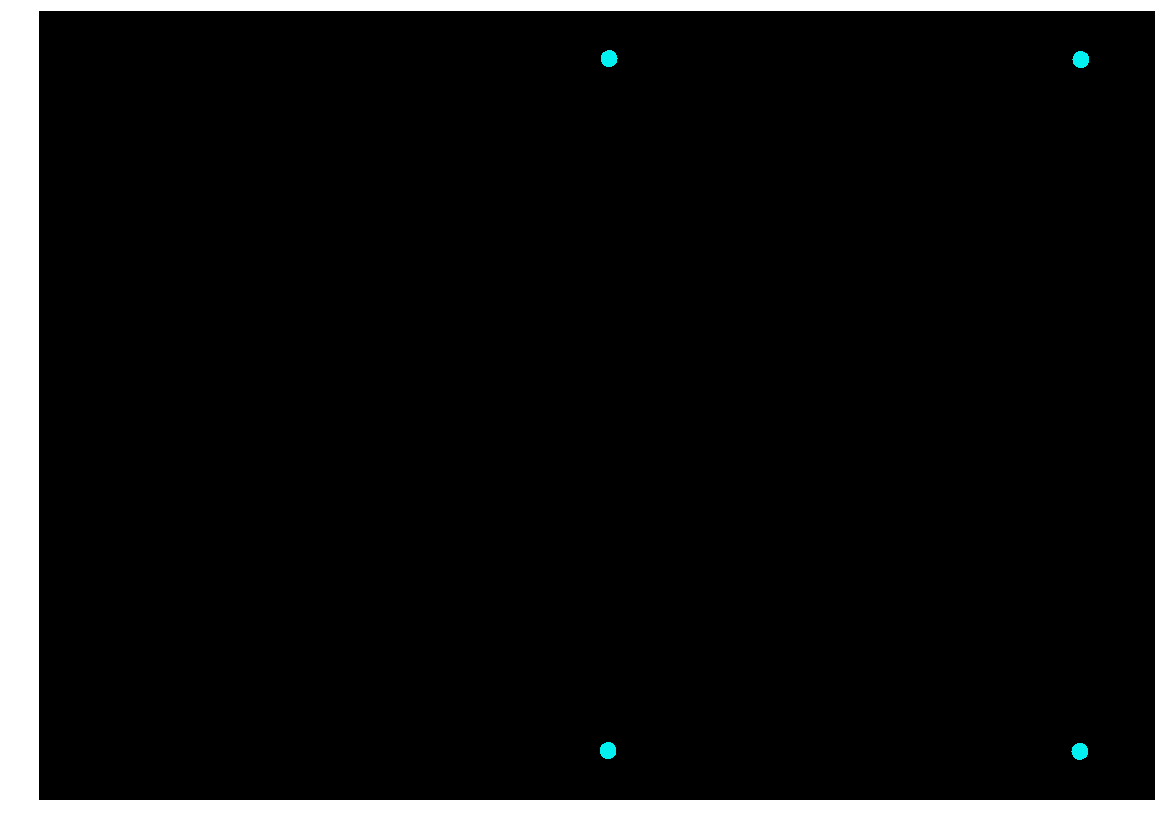

In [4]:
# 检测图片中的最外围轮廓
_,cnts,_ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
print("原始图片检测的轮廓总数：", len(cnts))

# 定义黑色背景幕布
black_background = np.ones(image.shape, np.uint8)*0
# 将检测到的轮廓添加幕布上进行展示
cv2.drawContours(black_background, cnts, -1, (3,240,240), 2)
fig = plt.figure(figsize=(20, 30))
plt.imshow(black_background)
plt.title(u"原始图片检测到的所有最外围轮廓")
plt.axis('off')

# 定义提取的轮廓总数
contour_size = 0
# 定义左右2个答题区域
answer_contour_1 = None
answer_contour_2 = None
if len(cnts) > 0:
    # 将轮廓按大小, 降序排序
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        # arcLength 计算周长 获取近似的轮廓
        peri = cv2.arcLength(c, True)
        print("轮廓周长：", peri)
        
        # approxPolyDP 多边形近似 https://blog.csdn.net/kakiebu/article/details/79824856
        # 之前寻找到的轮廓可能是多边形，现在通过寻找近似轮廓，得到期望的四边形
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        print('原始轮廓的边数:', len(c), ', 近似轮廓的边数:', len(approx))
        
        # 将近似轮廓绘制到原始图的相对位置上进行观察
        black_background = np.ones(image.shape,np.uint8)*0
        cv2.drawContours(black_background, approx, -1, (3,240,240), 50)
        fig = plt.figure(figsize=(20, 30))
        plt.imshow(black_background)
        plt.axis('off')
        
        # 当近似轮廓为4时，代表是需要提取的矩形区域
        if len(approx) == 4 and contour_size == 0:
            answer_contour_1 = approx
        if len(approx) == 4 and contour_size == 1:
            answer_contour_2 = approx
        
        # 只提取原始图中最大的两个轮廓
        contour_size = contour_size + 1
        if contour_size == 2:
            break

# 可能右侧区域轮廓比左侧的轮廓大, 后续需要根据ocr识别进一步区分左右区域
print(answer_contour_1)
print(answer_contour_2)

## 一、切割答题区域
### 3、针对左右答题区域轮廓进行透视变换, 提取答题区域

(-0.5, 1402.5, 2055.5, -0.5)

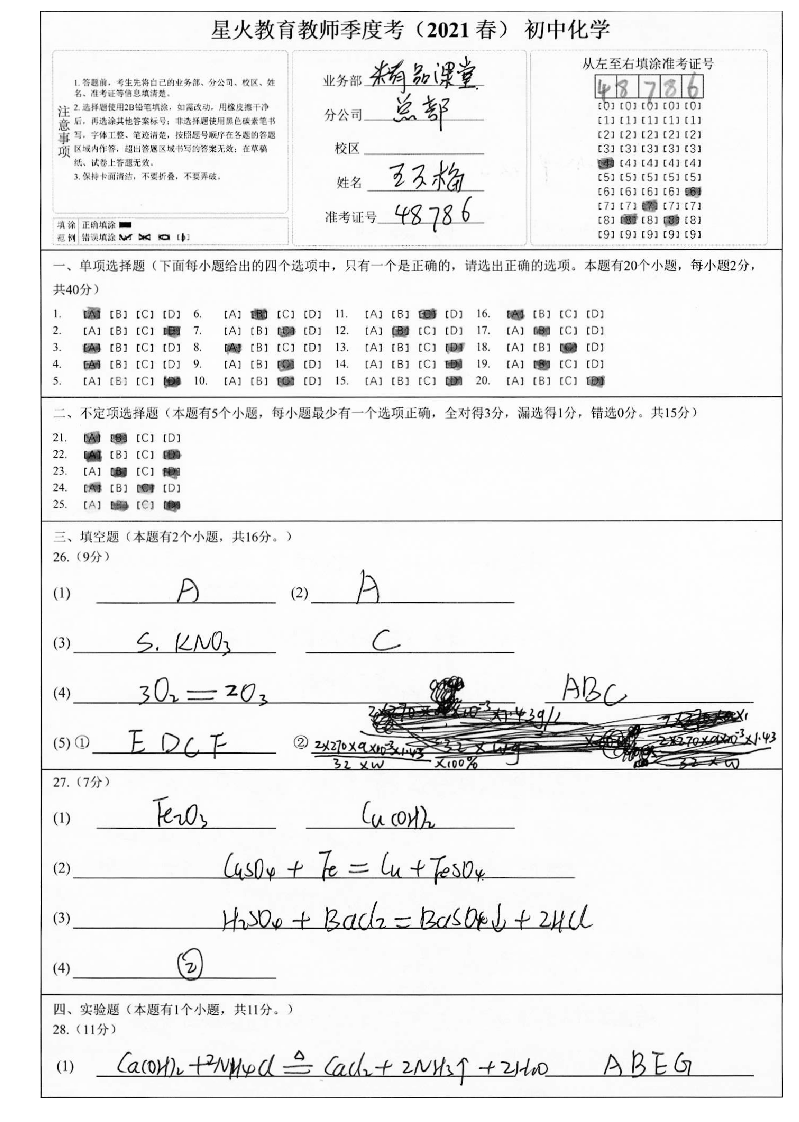

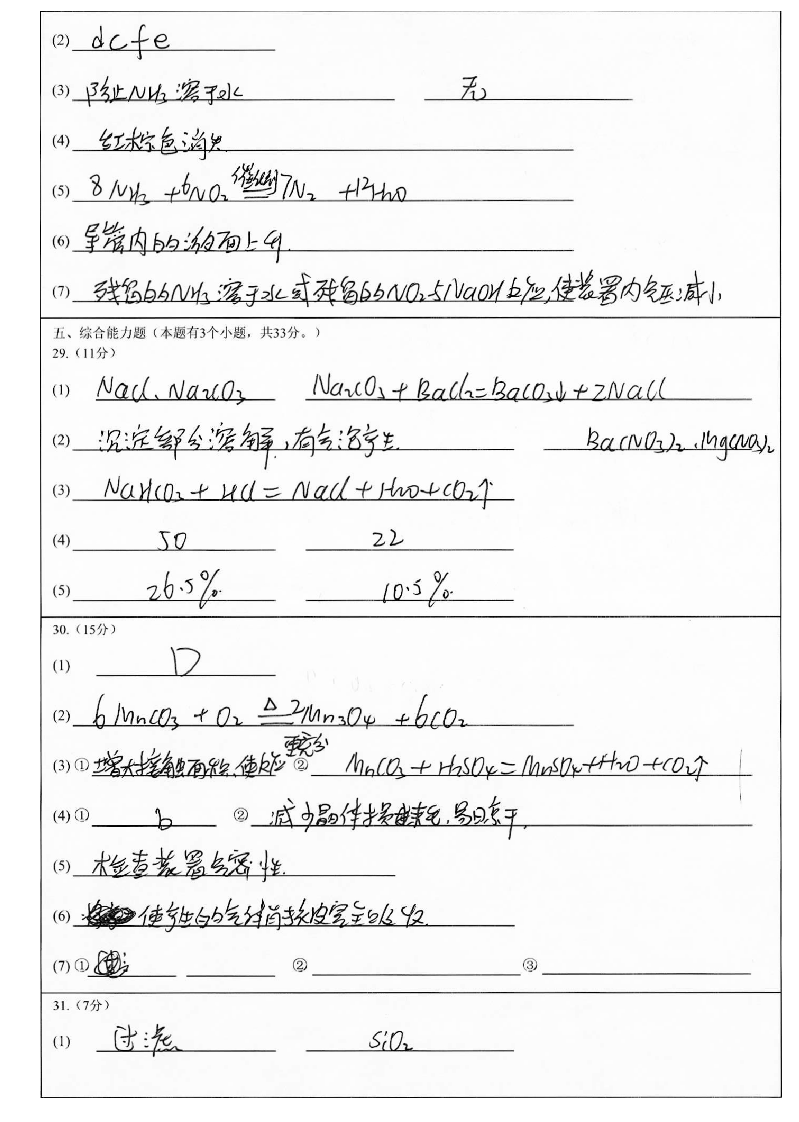

In [5]:
# 在灰度图上，进行四点透视变换
# 提取的answer_contour_1必须是四边形，不然reshape会失败
warped_answer_image_1 = four_point_transform(gray, answer_contour_1.reshape(4, 2))
warped_answer_image_2 = four_point_transform(gray, answer_contour_2.reshape(4, 2))


# 展示提取的左右答题区域
fig = plt.figure(figsize=(15, 20))
plt.imshow(warped_answer_image_1, cmap ='gray')
plt.axis('off')

fig = plt.figure(figsize=(15, 20))
plt.imshow(warped_answer_image_2, cmap ='gray')
plt.axis('off')

## 一、切割答题区域
### 4、提取答题区域的内部轮廓（以左侧答题区域为例）

findContours函数详解：https://blog.csdn.net/laobai1015/article/details/76400725

findContours 函数第二个参数取值类型：
- RETR_EXTERNAL	只检测最外围轮廓，包含在外围轮廓内的内围轮廓被忽略
- RETR_LIST	检测所有的轮廓，包括内围、外围轮廓，但是检测到的轮廓不建立等级关 系，彼此之间独立，没有等级关系，这就意味着这个检索模式下不存在父轮廓或内嵌轮廓
- ETR_CCOMP	检测所有的轮廓，但所有轮廓只建立两个等级关系，外围为顶层，若外围 内的内围轮廓还包含了其他的轮廓信息，则内围内的所有轮廓均归属于顶层
- RETR_TREE	检测所有轮廓，所有轮廓建立一个等级树结构。外层轮廓包含内层轮廓，内层轮廓还可以继续包含内嵌轮廓。

findContours 函数第三个参数取值类型：
- CHAIN_APPROX_NONE 保存物体边界上所有连续的轮廓点到contours向量内
- CHAIN_APPROX_SIMPLE 仅保存轮廓的拐点信息，把所有轮廓拐点处的点保存入contours向量内，拐点与拐点之间直线段上的信息点不予保留
- CHAIN_APPROX_TC89_L1，CHAIN_APPROX_TC89_KCOS使用teh-Chinl chain 近似算法

2501


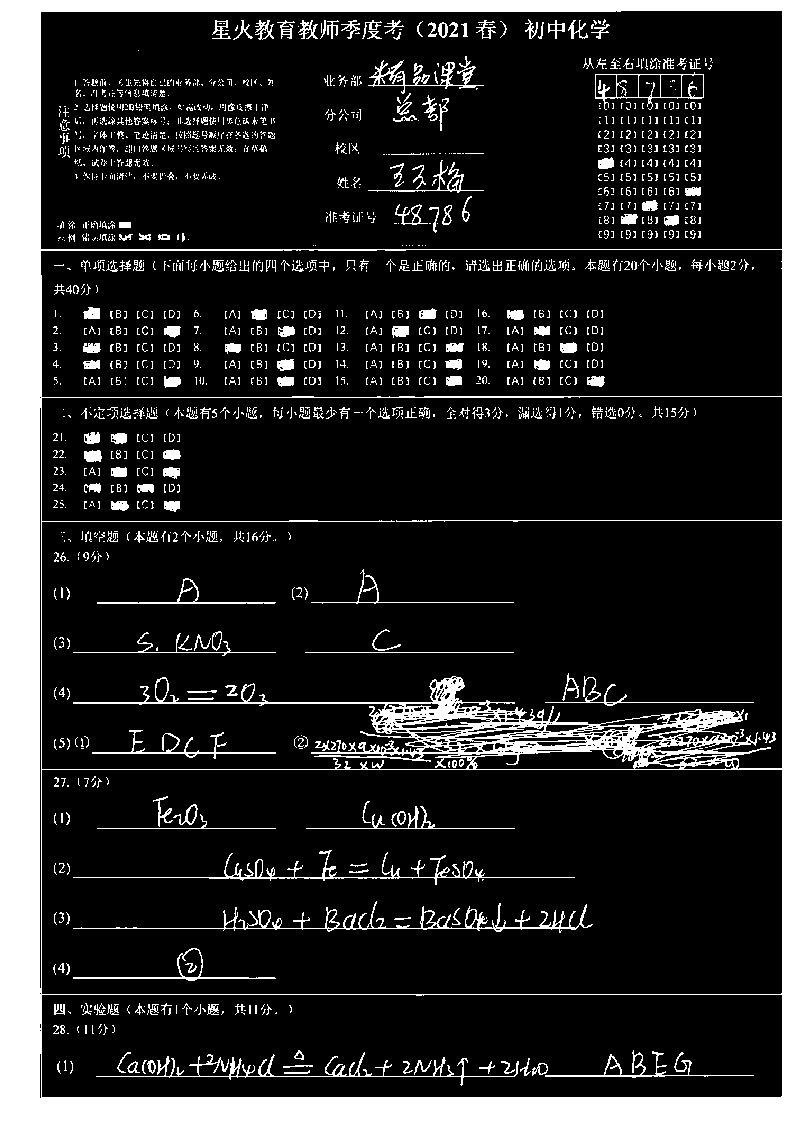

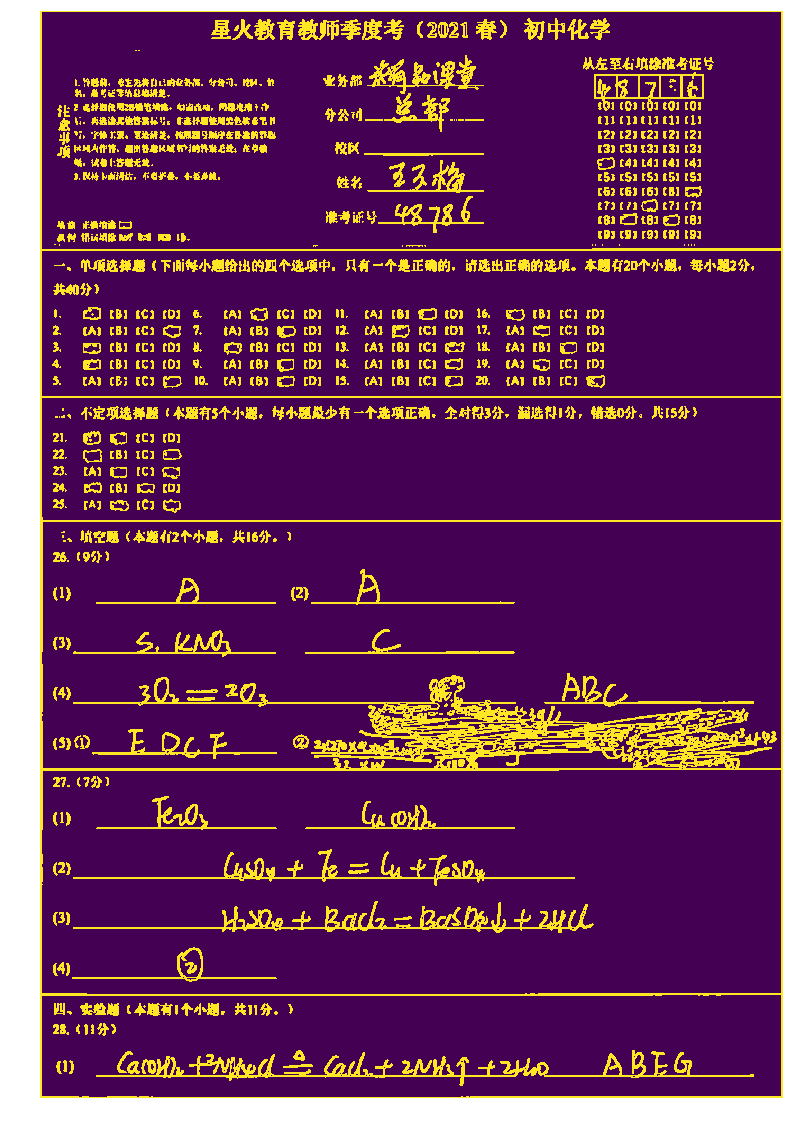

In [6]:
# OTSU二值化
thresh = cv2.threshold(warped_answer_image_1, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
fig = plt.figure(figsize=(15, 20))
plt.imshow(thresh, cmap ='gray')
plt.axis('off')

# findContours https://blog.csdn.net/laobai1015/article/details/76400725
# 在二值图像中查找轮廓，包括内围、外围轮廓，但是检测到的轮廓不建立等级关系，彼此之间独立
_,thresh_cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE )
black_background = np.ones(warped_answer_image_1.shape, np.uint8)*0
cv2.drawContours(black_background, thresh_cnts, -1, (3,240,240), 2)
fig = plt.figure(figsize=(15, 20))
plt.imshow(black_background)
plt.axis('off')

print(len(thresh_cnts))

## 一、切割答题区域
### 5、切割答题区域的子轮廓

轮廓周长： 6925.112697839737 宽: 1405
原始轮廓的边数: 43 , 近似轮廓的边数: 4
轮廓周长： 3704.1421353816986 宽: 1403
原始轮廓的边数: 19 , 近似轮廓的边数: 4
轮廓周长： 3652.526911377907 宽: 1402
原始轮廓的边数: 42 , 近似轮廓的边数: 4
轮廓周长： 9261.6420276165 宽: 1402
原始轮廓的边数: 1793 , 近似轮廓的边数: 4
轮廓周长： 3366.325900912285 宽: 1403
原始轮廓的边数: 65 , 近似轮廓的边数: 4
轮廓周长： 3277.7401144504547 宽: 1402
原始轮廓的边数: 66 , 近似轮廓的边数: 4
轮廓周长： 3205.7817445993423 宽: 1402
原始轮廓的边数: 100 , 近似轮廓的边数: 4


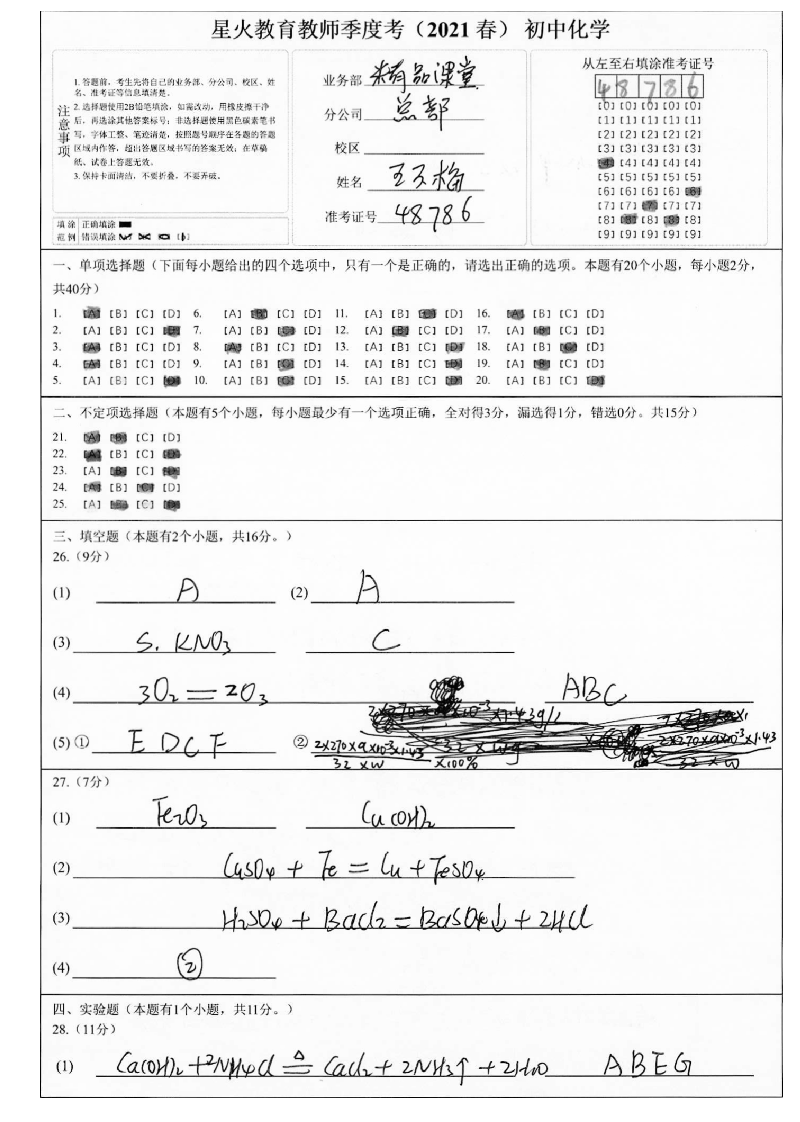

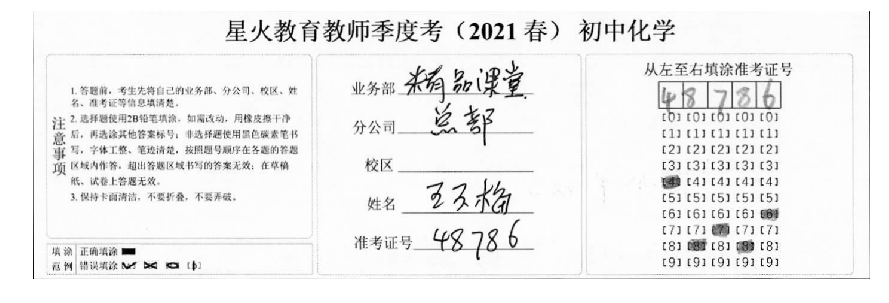

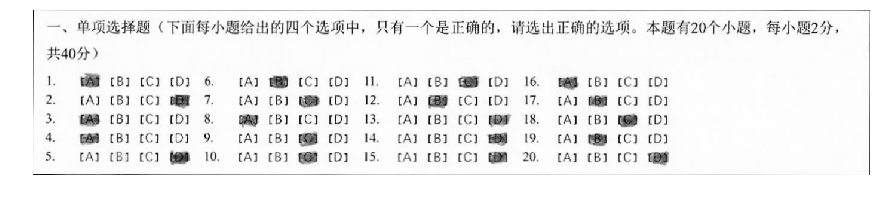

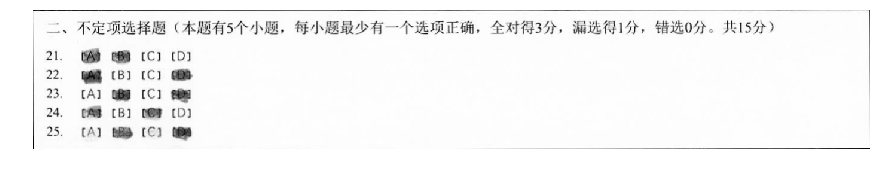

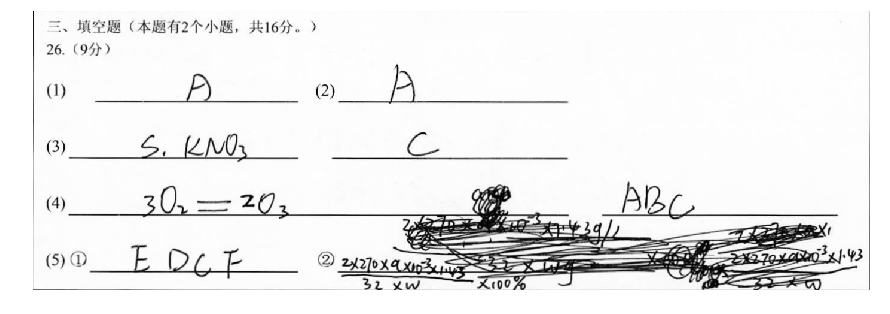

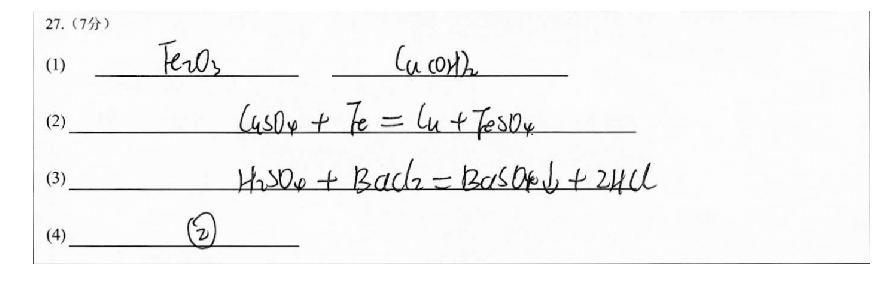

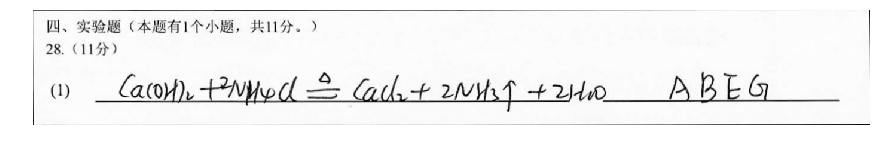

In [28]:
cnt_size = 0
all_answer_cnts = []
if len(thresh_cnts) > 0:
    # 将轮廓按大小, 降序排序
    thresh_cnts = sorted(thresh_cnts, key=cv2.contourArea, reverse=True)
    for c in thresh_cnts:
        cnt_size = cnt_size + 1
        
        # arcLength 计算周长
        peri = cv2.arcLength(c, True)
        
        # 计算轮廓的边界框
        (x, y, w, h) = cv2.boundingRect(c)
        
        # approxPolyDP 寻找近似轮廓：https://www.jianshu.com/p/6bde79df3f9d
        # 之前寻找到的轮廓可能是多边形，现在通过寻找近似轮廓，得到期望的四边形
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # 只提取近似轮廓为四边形的区域, 且轮廓长度大于指定长度
        if len(approx) == 4 and w > 1400:
            print("轮廓周长：", peri, '宽:', w)
            print('原始轮廓的边数:', len(c), ', 近似轮廓的边数:', len(approx))
            all_answer_cnts.append(approx)

        # 只处理前20个最大轮廓
        if  cnt_size >= 20:
            break           

# 从上到下，将轮廓排序
all_answer_cnts = sort_contours(all_answer_cnts, method="top-to-bottom")[0]
# print(len(all_answer_cnts))

# 依次打印每个轮廓
warped_option_answer = None
size = 0
for c in all_answer_cnts:
    warped_sub_answer_image = four_point_transform(warped_answer_image_1.copy(), c.reshape(4, 2))
    fig = plt.figure(figsize=(15, 20))
    plt.imshow(warped_sub_answer_image, cmap ='gray')
    plt.axis('off')
    
    size = size + 1
    if size == 3:
        warped_option_answer = warped_sub_answer_image

## 一、切割答题区域
### 6、TODO 集成ocr包, 识别所有图片左上角的序号，将图片与试题一一对应

---------------------------------------------------------------------

## 二、选择题自动批改
### 1、检测选择题区域的所有内外轮廓

findContours函数详解：https://blog.csdn.net/laobai1015/article/details/76400725

findContours 函数第二个参数取值类型：
- RETR_EXTERNAL	只检测最外围轮廓，包含在外围轮廓内的内围轮廓被忽略
- RETR_LIST	检测所有的轮廓，包括内围、外围轮廓，但是检测到的轮廓不建立等级关 系，彼此之间独立，没有等级关系，这就意味着这个检索模式下不存在父轮廓或内嵌轮廓
- ETR_CCOMP	检测所有的轮廓，但所有轮廓只建立两个等级关系，外围为顶层，若外围 内的内围轮廓还包含了其他的轮廓信息，则内围内的所有轮廓均归属于顶层
- RETR_TREE	检测所有轮廓，所有轮廓建立一个等级树结构。外层轮廓包含内层轮廓，内层轮廓还可以继续包含内嵌轮廓。

findContours 函数第三个参数取值类型：
- CHAIN_APPROX_NONE 保存物体边界上所有连续的轮廓点到contours向量内
- CHAIN_APPROX_SIMPLE 仅保存轮廓的拐点信息，把所有轮廓拐点处的点保存入contours向量内，拐点与拐点之间直线段上的信息点不予保留
- CHAIN_APPROX_TC89_L1，CHAIN_APPROX_TC89_KCOS使用teh-Chinl chain 近似算法

In [29]:
 # 初始化正确答案数的变量
correct = 0

# 构建标准答案字典
ANSWER_KEY = {
0: 1, 1: 4, 2: 1, 3: 1, 4: 4, 
5: 2, 6: 3, 7: 1, 8: 3, 9: 3,
10: 3, 11: 2, 12: 4, 13: 4, 14: 4, 
15: 1, 16: 2, 17: 3, 18: 2, 19: 4
}


(-0.5, 1400.5, 275.5, -0.5)

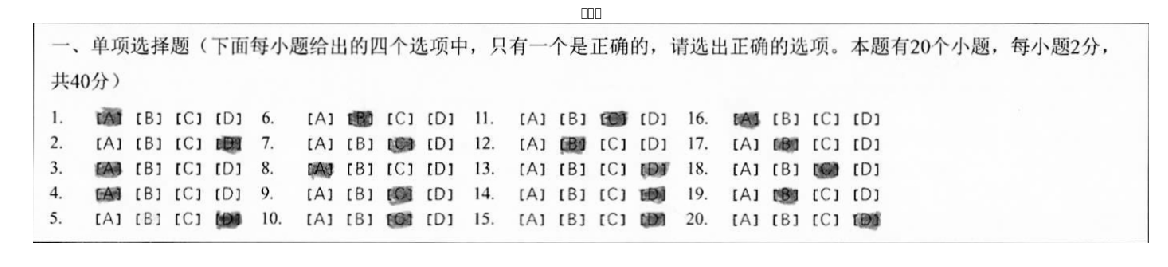

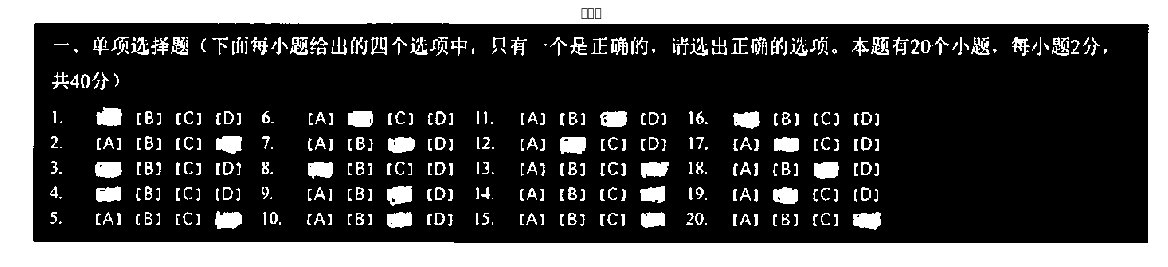

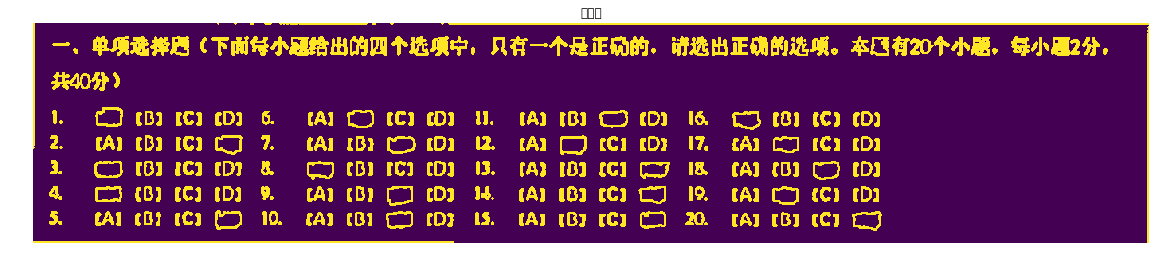

In [30]:
# 以单选选择题为例
fig = plt.figure(figsize=(20, 30))
plt.imshow(warped_option_answer, cmap ='gray')
plt.title(u'原始图')
plt.axis('off')

# OTSU二值化
thresh_option_answer = cv2.threshold(warped_option_answer, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
fig = plt.figure(figsize=(20, 30))
plt.imshow(thresh_option_answer, cmap ='gray')
plt.title(u'二值图')
plt.axis('off')

# 检测内外所有轮廓
# findContours https://blog.csdn.net/laobai1015/article/details/76400725
_,option_answer_cnts,_ = cv2.findContours(thresh_option_answer.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
black_background = np.ones(warped_option_answer.shape,np.uint8)*0
cv2.drawContours(black_background, option_answer_cnts, -1, (3,240,240), 2)
fig = plt.figure(figsize=(20, 30))
plt.title(u'轮廓图')
plt.imshow(black_background)
plt.axis('off')

## 二、选择题自动批改
### 2、提取选择题候选区域

(-0.5, 1400.5, 275.5, -0.5)

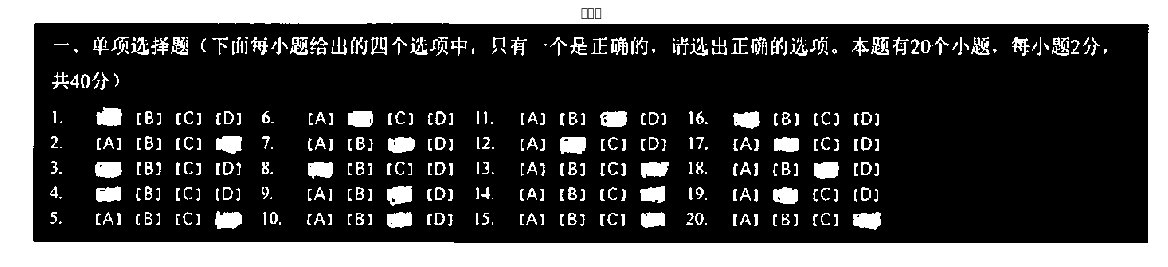

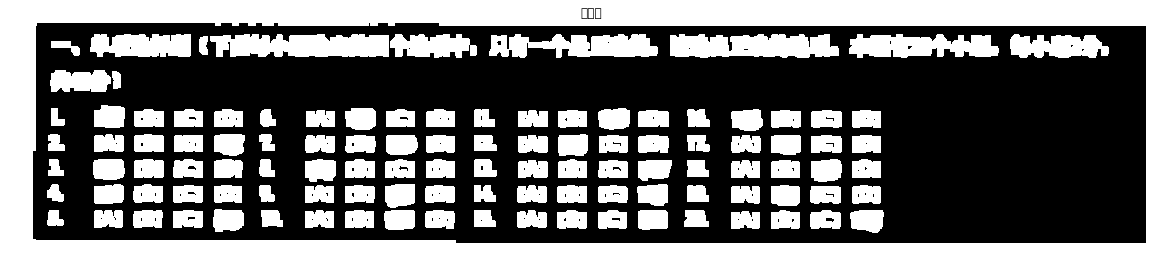

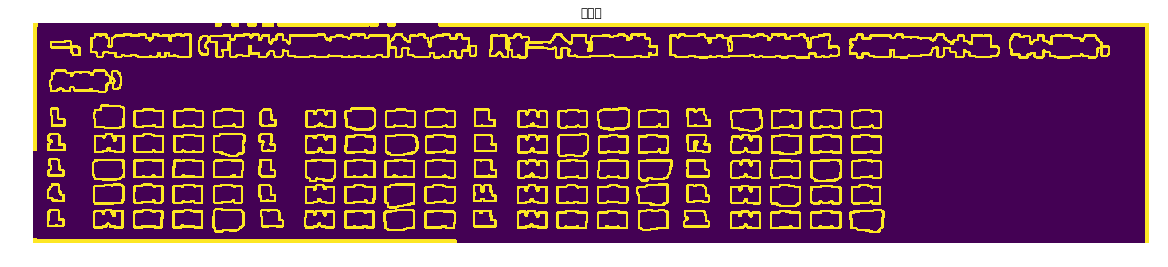

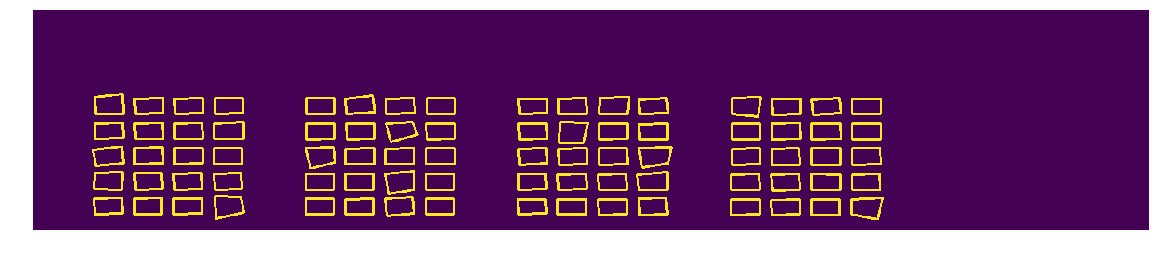

In [31]:
# 1、原二值化图
fig = plt.figure(figsize=(20, 30))
plt.imshow(thresh_option_answer, cmap ='gray')
plt.title(u'二值图')
plt.axis('off')

# 2、对高亮部分膨胀
# 因为候选区域由三部分组成（左括号、右括号、大写的英文字母），通过膨胀将三个区域连成一片
kernel = np.ones((7, 7), np.uint8)
dilate_choice_answer = cv2.dilate(thresh_option_answer, kernel, iterations=1) 
fig = plt.figure(figsize=(20, 30))
plt.imshow(dilate_choice_answer, cmap ='gray')
plt.title(u'二值图')
plt.axis('off')

# 3、提取膨胀后的轮廓
_, dilate_option_cnts, _ = cv2.findContours(dilate_choice_answer.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
black_background = np.ones(warped_option_answer.shape,np.uint8)*0
cv2.drawContours(black_background, dilate_option_cnts, -1, (3,240,240), 2)
fig = plt.figure(figsize=(20, 30))
plt.title(u'轮廓图')
plt.imshow(black_background)
plt.axis('off')

# 4、筛选轮廓中的选择题候选项
choiceAnswerCnts = [] # 初始化选择题候选区域
for c in dilate_option_cnts:

    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.06 * peri, True)
    # 计算轮廓的边界框
    (x, y, w, h) = cv2.boundingRect(approx) 
    # 计算宽高比
    ar = w / float(h)
    
    # 筛选轮廓为四边形的目前轮廓
    if len(approx) == 4:
        if  w >= 35 and w <= 60  and ar >= 0.5 and ar <= 2:
    #             print('坐标: ', (x, y, w, h))
            choiceAnswerCnts.append(approx)# 存储气泡轮廓
        
# 5、绘制筛选出来的候选项
black_background = np.ones(warped_option_answer.shape,np.uint8)*0
cv2.drawContours(black_background, choiceAnswerCnts, -1, (3,240,240), 2)
fig = plt.figure(figsize=(20, 30))
plt.imshow(black_background)
plt.axis('off')


## 二、选择题自动批改
### 3、提取涂改区域

(-0.5, 1400.5, 275.5, -0.5)

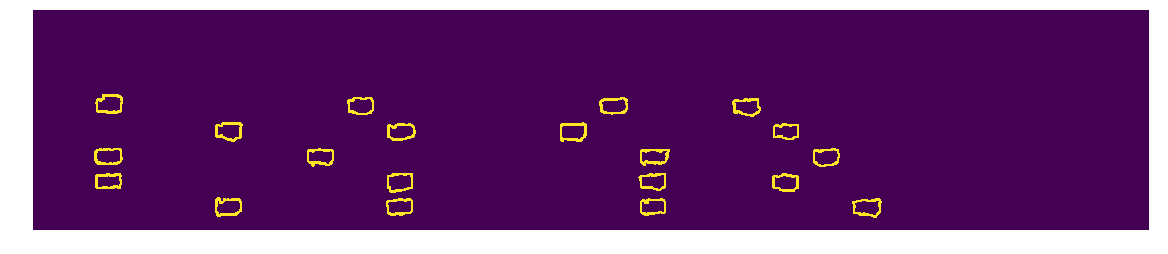

In [32]:
answerCnts = [] # 初始化选择题候选区域
for c in option_answer_cnts:
    # 计算轮廓的边界框
    (x, y, w, h) = cv2.boundingRect(c) 
    # 计算宽高比
    ar = w / float(h)
 
    # 筛选目标轮廓
    if  w >= 30 and w <= 40  and ar >= 1 and ar <= 3:
#         print('坐标: ', (x, y, w, h))
        answerCnts.append(c)# 存储气泡轮廓


black_background = np.ones(warped_option_answer.shape,np.uint8)*0
cv2.drawContours(black_background, answerCnts, -1, (3,240,240), 2)
fig = plt.figure(figsize=(20, 30))
plt.imshow(black_background)
plt.axis('off')

## 二、选择题自动批改
### 4、根据候选区域与涂改区进行自动批改

80
80


(-0.5, 1400.5, 275.5, -0.5)

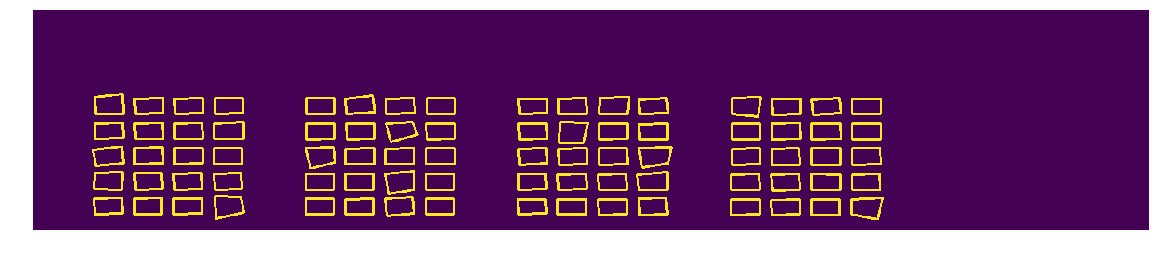

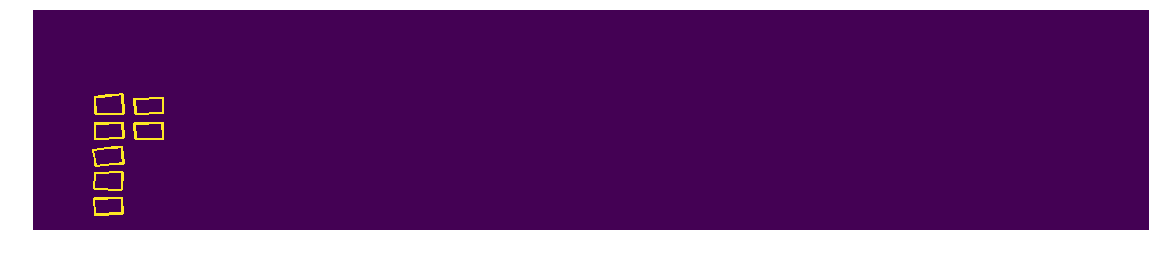

In [20]:
black_background = np.ones(warped_option_answer.shape,np.uint8)*0
cv2.drawContours(black_background, choiceAnswerCnts, -1, (3,240,240), 2)
fig = plt.figure(figsize=(20, 30))
plt.imshow(black_background)
plt.axis('off')

print(len(choiceAnswerCnts))

# 从左到右，从上到下，将轮廓排序
sortChoiceAnswerCnts = []
choiceAnswerCnts = sort_contours(choiceAnswerCnts, method="left-to-right")[0]
for i in range(0,len(choiceAnswerCnts), 5):
    subChoiceAnswerCnts = choiceAnswerCnts[i:i+5]
    subChoiceAnswerCnts = sort_contours(subChoiceAnswerCnts, method="top-to-bottom")[0]
    sortChoiceAnswerCnts = sortChoiceAnswerCnts + list(subChoiceAnswerCnts)
print(len(sortChoiceAnswerCnts))
# print(sortChoiceAnswerCnts)
choiceAnswerCnts = sortChoiceAnswerCnts

black_background = np.ones(warped_option_answer.shape,np.uint8)*0
cv2.drawContours(black_background, choiceAnswerCnts[:7], -1, (3,240,240), 2)
fig = plt.figure(figsize=(20, 30))
plt.imshow(black_background)
plt.axis('off')

